# ML HW3


In [20]:
import os

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from scipy.stats import multivariate_normal
from sklearn import svm

## 1. Support Vector Machine


In [21]:
data = pd.read_csv('./x_train.csv', header=None) / 255.0
data = np.array(data)
data = data - np.mean(data, axis=0)

label = pd.read_csv('./t_train.csv', header=None)
label = np.array(label).reshape(-1)


### Principal Component Analysis (PCA)


In [22]:
class PCA:
    eigenvalues: np.ndarray
    eigenvectors: np.ndarray

    def __init__(self, n_components) -> None:
        self.n_components = n_components

    def fit(self, x):
        """
        Args:
            x: (n_samples, n_features)
        Returns:
            self
        """
        u, s, vh = np.linalg.svd(x, full_matrices=False)
        self.eigenvalues = np.square(s) / (x.shape[0] - 1)
        self.eigenvectors = vh.T[:, :self.n_components]
        return self

    def transform(self, x):
        """
        Args:
            x: (n_samples, n_features)
        Returns:
            (n_samples, n_components)
        """
        return x @ self.eigenvectors

    def fit_transform(self, x):
        return self.fit(x).transform(x)

    def components(self):
        """
        Returns:
            (n_components, n_features)
        """
        return self.eigenvectors.T

    def explained_variance(self):
        return self.eigenvalues[:self.n_components]

    def explained_variance_ratio(self):
        return self.eigenvalues[:self.n_components] / np.sum(self.eigenvalues)

In [23]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)
print(pca_data.shape)

(300, 2)


### Decision Approaches

1. one-vs-one

   Choose two classes each time, and train a binary classifier for each pair of classes. Then, for a new sample, we can use the binary classifiers to predict the class of the sample. Finally, we can choose the class that has the most votes.

2. one-vs-rest

   Choose one class as the positive class, and the rest as the negative class. Then, we can train a binary classifier for each class. Finally, we can choose the class that has the most votes.

In this case, both approaches will train three binary classifiers. Here. I will use **one-vs-one** approach because it use only two classes of data each time, and it is more efficient than one-vs-rest approach.


### Support Vector Machine (SVM)


In [24]:
from typing import Literal


class Kernel:

    def __init__(self, mode: Literal['Linear', 'Polynomial']) -> None:
        if mode not in ['Linear', 'Polynomial']:
            raise ValueError(f'Unknown mode: {mode}, should be `Linear` or `Polynomial`')

        self.mode = mode

    def phi(self, x: np.ndarray):
        if self.mode == 'Linear':
            return x
        else:  # self.mode == 'Polynomial':
            return np.array([
                np.square(x[..., 0]),
                np.sqrt(2) * x[..., 0] * x[..., 1],
                np.square(x[..., 1]),
            ]).T

    def compute_kernel(self, x1, x2):
        return self.phi(x1) @ self.phi(x2).T


In [25]:
class SVM:
    coef: np.ndarray
    sv_idx: np.ndarray
    weight: np.ndarray
    bias: np.floating

    def __init__(self, pos_cls, neg_cls, kernel: Kernel, C=1.0) -> None:
        self.kernel = kernel
        self.C = C
        self.pos_cls = pos_cls
        self.neg_cls = neg_cls

    def compute_weight_and_bias(self, alpha, x, t):
        weight = (alpha * t).T @ self.kernel.phi(x)

        m_idx = np.logical_and(self.C > alpha, alpha > 0)
        s_idx = alpha > 0

        kernels = self.kernel.compute_kernel(x[m_idx], x[s_idx])
        bias = np.mean(t[m_idx] - kernels @ (alpha * t)[s_idx])

        return weight, bias

    def fit(self, x, t):
        t = np.where(t == self.pos_cls, 1.0, -1.0)

        from sklearn.svm import SVC
        if self.kernel.mode == 'Linear':
            clf = SVC(kernel='linear', C=self.C, decision_function_shape='ovo')
        else:  # self.kernel.mode == 'Polynomial'
            clf = SVC(kernel='poly', C=self.C, degree=2, decision_function_shape='ovo')
        clf.fit(x, t)

        self.coef = np.abs(clf.dual_coef_).reshape(-1)
        self.sv_idx = clf.support_

        alpha = np.zeros_like(t)
        alpha[self.sv_idx] = self.coef
        self.weight, self.bias = self.compute_weight_and_bias(alpha, x, t)

        return self

    def predict(self, x):
        pred = np.sign(self.kernel.phi(x) @ self.weight.T + self.bias)
        return np.where(pred == 1.0, self.pos_cls, self.neg_cls)


In [26]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot(x, y, sv_idx, xx, yy, pred, title):
    c1_idx = np.where(y == 0)
    c2_idx = np.where(y == 1)
    c3_idx = np.where(y == 2)
    plt.figure()
    plt.title(title)
    plt.scatter(x[sv_idx, 0],
                x[sv_idx, 1],
                s=100,
                facecolors='none',
                edgecolors='k',
                label='Support Vector')
    plt.scatter(x[c1_idx, 0], x[c1_idx, 1], c='b', marker='x', label='T-shirt/top')
    plt.scatter(x[c2_idx, 0], x[c2_idx, 1], c='r', marker='x', label='Trouser')
    plt.scatter(x[c3_idx, 0], x[c3_idx, 1], c='g', marker='x', label='Sandal')
    plt.contourf(xx, yy, pred, alpha=0.2, cmap=plt.cm.brg)
    plt.legend()
    plt.show()


def vote(y):
    classes = np.arange(3)
    counts = np.empty((*(y.shape[:-1]), 3))
    for cls in classes:
        counts[..., cls] = np.sum(y == cls, axis=-1)

    return np.argmax(counts, axis=-1)


#### Linear SVM


In [27]:
linear_kernel = Kernel(mode='Linear')
C = 1.0
linear_svm = []

for c1, c2 in [[0, 1], [0, 2], [1, 2]]:
    idx = np.logical_or(label == c1, label == c2)
    x = pca_data[idx]
    y = label[idx]
    svm = SVM(c1, c2, linear_kernel, C=C).fit(x, y)
    linear_svm.append(svm)

    print(f'Class {c1} vs Class {c2}')
    print(f'Number of support vectors: {len(svm.sv_idx)}')
    print(f'Accuracy: {np.mean(svm.predict(x) == y)}')
    print()


Class 0 vs Class 1
Number of support vectors: 30
Accuracy: 0.94

Class 0 vs Class 2
Number of support vectors: 11
Accuracy: 0.985

Class 1 vs Class 2
Number of support vectors: 3
Accuracy: 1.0



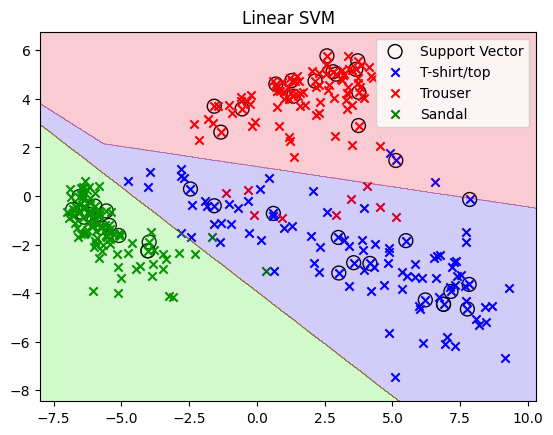

In [28]:
sv_idx = np.concatenate([svm.sv_idx for svm in linear_svm])

xx, yy = make_meshgrid(pca_data[:, 0], pca_data[:, 1])

grid_data = np.stack([xx.ravel(), yy.ravel()], axis=-1)
pred = np.empty((xx.shape[0], xx.shape[1], len(linear_svm)))
for i, svm in enumerate(linear_svm):
    pred[..., i] = svm.predict(grid_data).reshape(xx.shape)

pred = vote(pred)

plot(pca_data, label, sv_idx, xx, yy, pred, 'Linear SVM')

#### Polynomial SVM


In [29]:
poly_kernel = Kernel(mode='Polynomial')
C = 1.0
poly_svm = []

for c1, c2 in [[0, 1], [0, 2], [1, 2]]:
    idx = np.logical_or(label == c1, label == c2)
    x = pca_data[idx]
    y = label[idx]
    svm = SVM(c1, c2, poly_kernel, C=C).fit(x, y)
    poly_svm.append(svm)

    print(f'Class {c1} vs Class {c2}')
    print(f'Number of support vectors: {len(svm.sv_idx)}')
    print(f'Accuracy: {np.mean(svm.predict(x) == y)}')
    print()


Class 0 vs Class 1
Number of support vectors: 65
Accuracy: 0.825

Class 0 vs Class 2
Number of support vectors: 43
Accuracy: 0.95

Class 1 vs Class 2
Number of support vectors: 49
Accuracy: 0.925



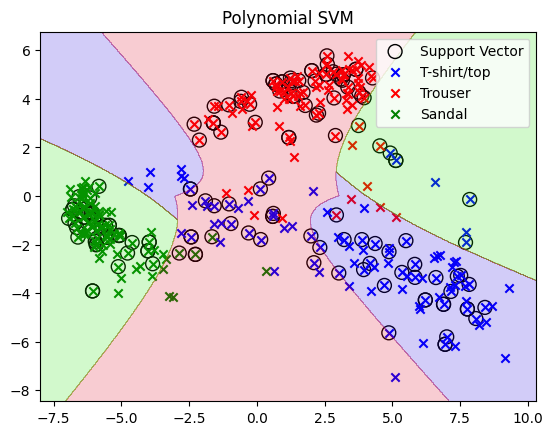

In [30]:
sv_idx = np.concatenate([svm.sv_idx for svm in poly_svm])

xx, yy = make_meshgrid(pca_data[:, 0], pca_data[:, 1])

grid_data = np.stack([xx.ravel(), yy.ravel()], axis=-1)
pred = np.empty((xx.shape[0], xx.shape[1], len(poly_svm)))
for i, svm in enumerate(poly_svm):
    pred[..., i] = svm.predict(grid_data).reshape(xx.shape)

pred = vote(pred)

plot(pca_data, label, sv_idx, xx, yy, pred, 'Polynomial SVM')

## 2. Gaussian Mixture Model


In [31]:
with Image.open('./hw3.jpg') as img:
    image = np.array(img)

### KMeans

In [32]:
class KMeans:
    means: np.ndarray
    idicators: np.ndarray
    x: np.ndarray

    def __init__(self, k, max_iter=100):
        self.k = k
        self.max_iter = max_iter

    def fit(self, x):
        self.x = x
        self.means = x[np.random.choice(x.shape[0], self.k, replace=False)]
        self.indicators = np.zeros((x.shape[0], self.k), dtype=np.int8)

        for _ in range(self.max_iter):
            dist_2 = np.linalg.norm(x[:, None] - self.means, ord=2, axis=-1)**2
            self.indicators = (dist_2 == np.min(dist_2, axis=-1, keepdims=True))

            self.means = np.mean(
                x[:, None] * self.indicators[..., None],
                axis=0,
                where=self.indicators[..., None],
            )
        return self

    def predict(self, x):
        dist_2 = np.linalg.norm(x[:, None] - self.means, ord=2, axis=-1)**2
        return np.argmin(dist_2, axis=-1)

    def get_means(self):
        return self.means

    def get_data_ratio(self):
        return np.mean(self.indicators, axis=0)

    def get_covariance(self):
        cov = []
        for i in range(self.k):
            cov.append(np.cov(self.x[self.indicators[:, i]], rowvar=False))
        return np.array(cov)

    def show_means_table(self, title):
        print(title)
        print(pd.DataFrame(self.means.astype(np.uint8), columns=['R', 'G', 'B']))

    def plot_quantized_image(self, title, image):
        quantized_image = self.means[self.predict(image.reshape(-1, 3))]
        quantized_image = quantized_image.reshape(image.shape).astype(np.uint8)
        plt.imshow(quantized_image)
        plt.title(title)
        plt.axis('off')
        plt.show()

### GMM

In [33]:
class GMM:
    pi: np.ndarray
    means: np.ndarray
    covs: np.ndarray
    x: np.ndarray

    def __init__(self, k, max_iter=100):
        self.k = k
        self.max_iter = max_iter
        self.log_likelihood = []

    def init(self, pi, means, covs):
        self.pi = pi
        self.means = means
        self.covs = covs
        return self

    def fit(self, x):
        for _ in range(self.max_iter):
            # E-step
            pdf = np.array([
                multivariate_normal.pdf(x, mean, cov) for mean, cov in zip(self.means, self.covs)
            ]).T
            joint_dist = self.pi * pdf
            gamma = joint_dist / np.sum(joint_dist, axis=-1, keepdims=True)  # [N, K]
            # M-step
            N_k = np.sum(gamma, axis=0)
            self.means = gamma.T @ x / N_k[:, None]

            tmp = x.T[None] - self.means[..., None]  # [K, 3, N]
            self.covs = (tmp * gamma.T[:, None]) @ np.transpose(tmp, (0, 2, 1)) / N_k[:, None, None]

            self.pi = N_k / x.shape[0]

            self.log_likelihood.append(np.sum(np.log(np.sum(joint_dist, axis=-1))))

        return self

    def predict(self, x):
        pdf = np.array(
            [multivariate_normal.pdf(x, mean, cov) for mean, cov in zip(self.means, self.covs)]).T
        joint_dist = self.pi * pdf
        return np.argmax(joint_dist, axis=-1)

    def show_means_table(self, title):
        print(title)
        print(pd.DataFrame(self.means.astype(np.uint8), columns=['R', 'G', 'B']))

    def plot_quantized_image(self, title, image):
        quantized_image = self.means[self.predict(image.reshape(-1, 3))]
        quantized_image = quantized_image.reshape(image.shape).astype(np.uint8)
        plt.imshow(quantized_image)
        plt.title(title)
        plt.axis('off')
        plt.show()

    def plot_log_likelihood(self, title):
        plt.plot(self.log_likelihood)
        plt.title(title)
        plt.xlabel('Iteration')
        plt.ylabel('Log Likelihood')
        plt.show()

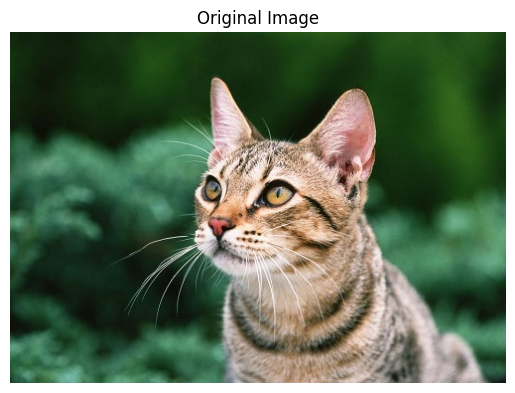

In [34]:
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

K-means K = 2
     R    G    B
0  176  165  147
1   35   68   37


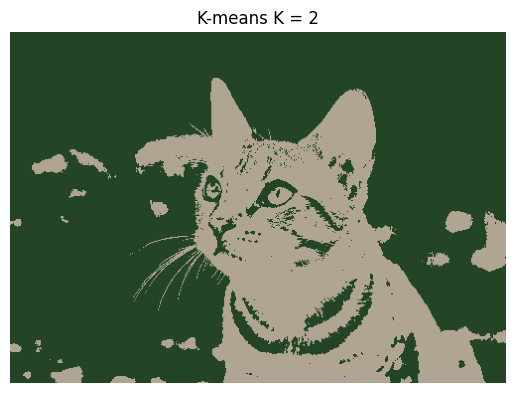

GMM K = 2
     R    G    B
0  173  152  136
1   34   72   40


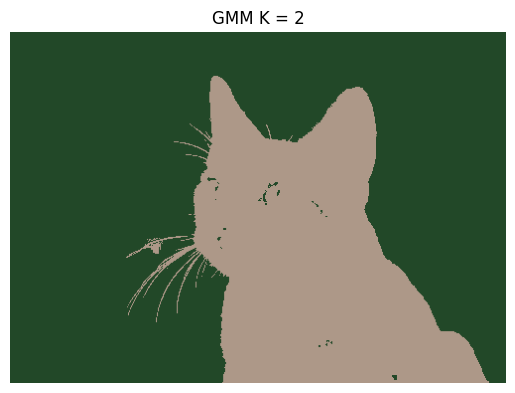

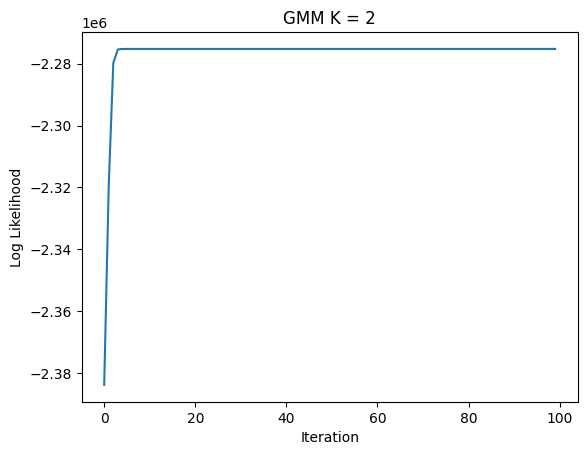

In [35]:
K = 2

kmeans = KMeans(K).fit(image.reshape(-1, 3))

pi = kmeans.get_data_ratio()
means = kmeans.get_means()
covs = kmeans.get_covariance()

gmm = GMM(K).init(pi, means, covs).fit(image.reshape(-1, 3))

kmeans.show_means_table(f'K-means K = {K}')
kmeans.plot_quantized_image(f'K-means K = {K}', image)
gmm.show_means_table(f'GMM K = {K}')
gmm.plot_quantized_image(f'GMM K = {K}', image)
gmm.plot_log_likelihood(f'GMM K = {K}')

K-means K = 3
     R    G    B
0   84  119   90
1   24   54   22
2  201  178  163


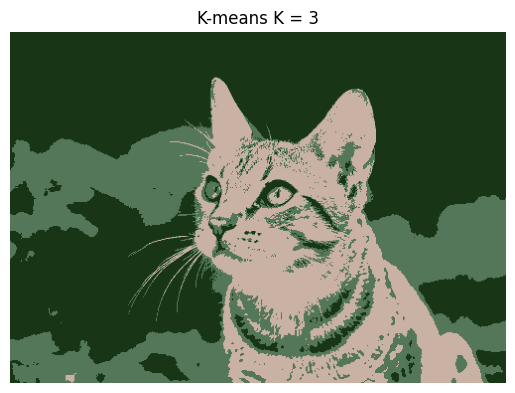

GMM K = 3
     R    G    B
0   48   95   66
1   22   52   16
2  172  151  135


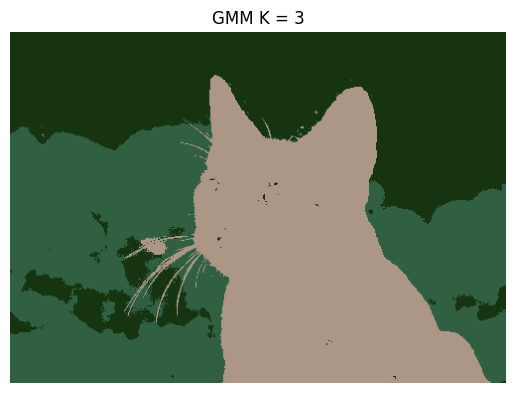

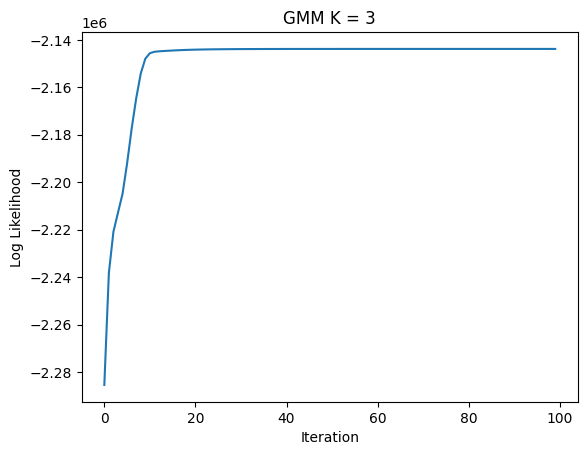

In [36]:
K = 3

kmeans = KMeans(K).fit(image.reshape(-1, 3))

pi = kmeans.get_data_ratio()
means = kmeans.get_means()
covs = kmeans.get_covariance()

gmm = GMM(K).init(pi, means, covs).fit(image.reshape(-1, 3))

kmeans.show_means_table(f'K-means K = {K}')
kmeans.plot_quantized_image(f'K-means K = {K}', image)
gmm.show_means_table(f'GMM K = {K}')
gmm.plot_quantized_image(f'GMM K = {K}', image)
gmm.plot_log_likelihood(f'GMM K = {K}')

K-means K = 7
     R    G    B
0  148  123  102
1   81  139  105
2   18   40   16
3  190  165  149
4   32   72   30
5  229  208  199
6   59  101   72


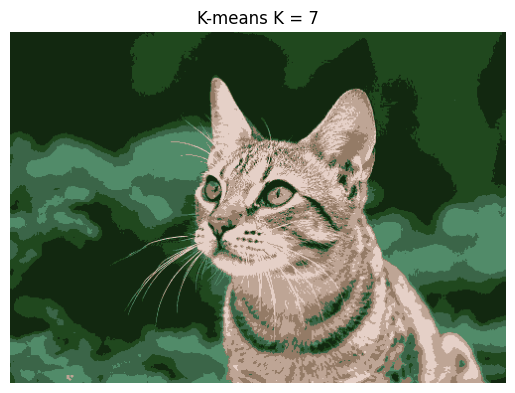

GMM K = 7
     R    G    B
0  133  123  109
1   60  115   82
2   20   49   15
3  172  149  127
4   34   79   22
5  210  196  191
6   19   41   24


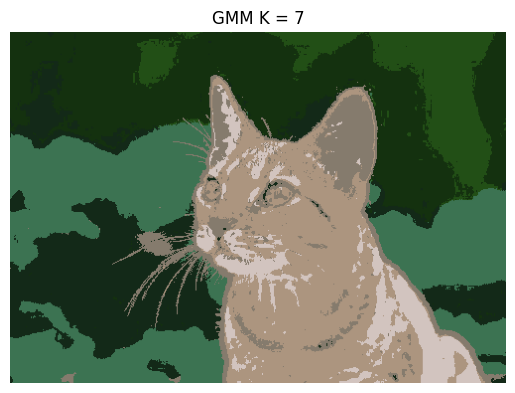

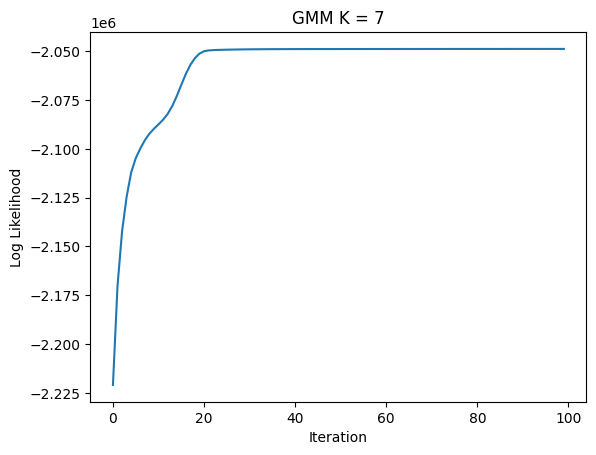

In [37]:
K = 7

kmeans = KMeans(K).fit(image.reshape(-1, 3))

pi = kmeans.get_data_ratio()
means = kmeans.get_means()
covs = kmeans.get_covariance()

gmm = GMM(K).init(pi, means, covs).fit(image.reshape(-1, 3))

kmeans.show_means_table(f'K-means K = {K}')
kmeans.plot_quantized_image(f'K-means K = {K}', image)
gmm.show_means_table(f'GMM K = {K}')
gmm.plot_quantized_image(f'GMM K = {K}', image)
gmm.plot_log_likelihood(f'GMM K = {K}')

K-means K = 20
      R    G    B
0    56  110   78
1    98   83   62
2    29   72   20
3   214  190  178
4    23   60   16
5    28   58   35
6    45   94   64
7    40   87   25
8    20   48   17
9    82  142  106
10  137  114   93
11   35   76   49
12   15   25   12
13  169  141  121
14  239  220  212
15   16   38   13
16   69  125   91
17  190  166  150
18   18   37   23
19  103  158  128


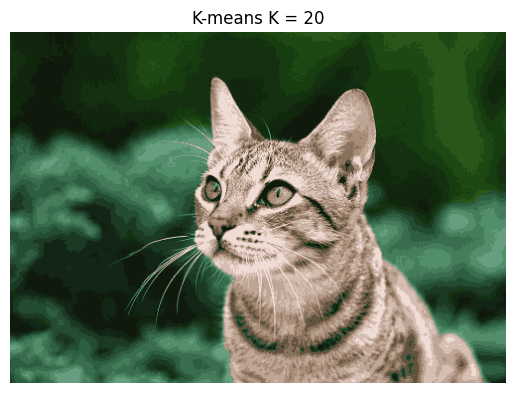

GMM K = 20
      R    G    B
0    56  112   80
1    30   42   23
2    31   75   21
3   217  188  169
4    23   61   16
5    24   58   34
6    50   99   59
7    41   90   24
8    20   48   16
9    74  136  100
10  138  117   94
11   39   87   58
12   16   33   19
13  187  153  145
14  244  224  213
15   16   35   12
16   83  142  104
17  192  172  157
18   15   31   20
19   95  119  102


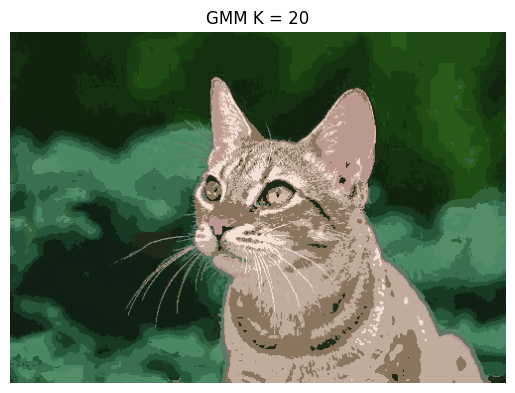

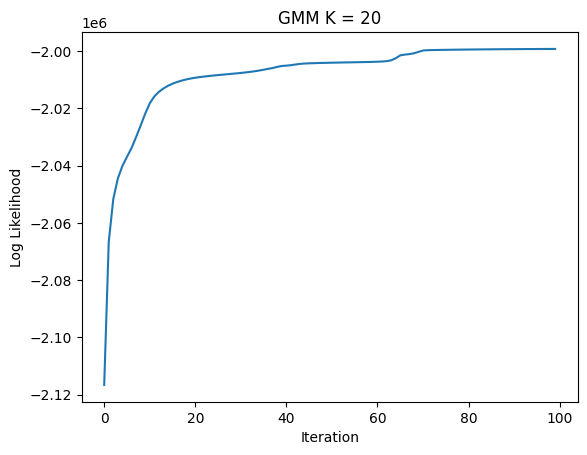

In [38]:
K = 20

kmeans = KMeans(K).fit(image.reshape(-1, 3))

pi = kmeans.get_data_ratio()
means = kmeans.get_means()
covs = kmeans.get_covariance()

gmm = GMM(K).init(pi, means, covs).fit(image.reshape(-1, 3))

kmeans.show_means_table(f'K-means K = {K}')
kmeans.plot_quantized_image(f'K-means K = {K}', image)
gmm.show_means_table(f'GMM K = {K}')
gmm.plot_quantized_image(f'GMM K = {K}', image)
gmm.plot_log_likelihood(f'GMM K = {K}')

### Discussion

- KMeans
  - Only find the circular clusters
  - Remain more details in the image

- GMM
  - Consider the covariance of the data and able to find the oval clusters
  - Segment the image well
